In [1]:
using Flux, DiffEqFlux, Plots, DifferentialEquations, Random, Optim, Interact
Random.seed!(1);

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /home/julius/.julia/packages/CUDAdrv/b1mvw/src/CUDAdrv.jl:67
┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1273
┌ Info: Precompiling Interact [c601a237-2ae4-5e1e-952c-7a85b0c7eef1]
└ @ Base loading.jl:1273


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-9967467308215728124\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13652020335299576937\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-9967467308215728124\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

# Neural Differential Equations in Julia
> Exploring the [Flux.jl](https://github.com/FluxML/Flux.jl) and [DiffEqFlux.jl](https://github.com/JuliaDiffEq/DiffEqFlux.jl) packages. 


## Warm-Up: Using Flux for Linear Regression

[Flux](https://julialang.org/blog/2018/12/ml-language-compiler/): "...typical frameworks are all-encompassing monoliths in hundreds of thousands of lines of C++, Flux is only a thousand lines of straightforward Julia code. Simply take one package for gradients (Zygote.jl), one package for GPU support (CuArrays.jl), sprinkle with some light convenience functions, bake for fifteen minutes and out pops a fully-featured ML stack."

**Problem:** Given data $(x_i,y_i)_{i=0}^m$ we want to approximately solve the problem 

$$ \min_{W,b} \sum_{i=0}^m \| W*x_i+b - y_i \|_2^2. $$

0.4926699712690374


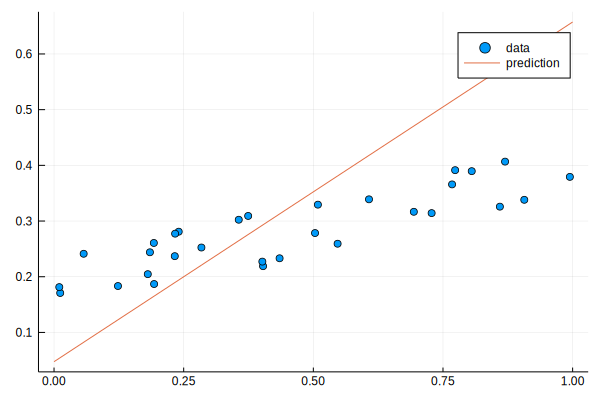

In [10]:
# model
W = rand(1)
b = rand(1)

# prediction
pred(x) = W.*x .+ b

# loss
loss(x, y) = sum(abs2, (y .- pred(x)))

# data
samples = 30
noise = 0.1

x = rand(samples)
y = rand(1).*x .+ rand(1) .+ noise.*rand(samples) 

# initial loss
println(loss(x, y))

# plot
scatter(x, y, label="data")
dx = range(0, 1; length=100)
# Note: mutating/in-place functions have names that end in !
plot!(dx, pred(dx), label="prediction")

**Idea:** To improve the prediction we can take the gradients of W and b with respect to the loss and perform gradient descent.

In contrast to TensorFlow or PyTorch in Python this is possible without tracing the operations in advance (Julia is just-in-time compiled, the *computational graph* is Julia’s own syntax).

Step: 20 Loss: 0.10495204253453672
Step: 40 Loss: 0.04693479465886506
Step: 60 Loss: 0.035843016058196044
Step: 80 Loss: 0.033722481957890175
Step: 100 Loss: 0.033317076744492864


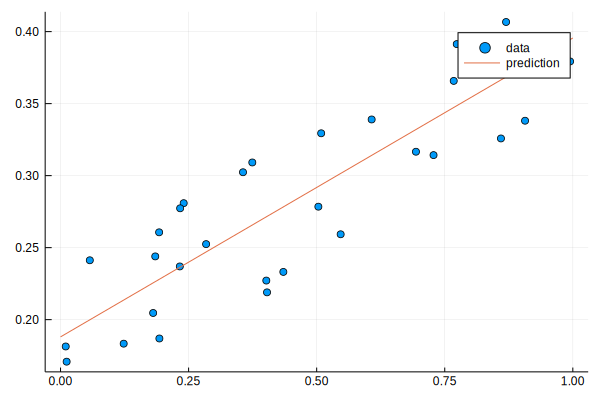

In [11]:
# gradient steps
steps = 100
# learning rate
lr = 0.01

# gradient descent
for i=1:steps
  gs = gradient(() -> loss(x, y), params(W, b))
  W .-= lr .* gs[W]
  b .-= lr .* gs[b]
  if i%20==0
    println("Step: $i Loss: $(loss(x, y))")
  end
end

# plot
scatter(x, y, label="data")
dx = range(0, 1; length=100)
plot!(dx, pred(dx), label="prediction")

## Neural Differential Equations using DiffEqFlux

[DiffEqFlux](https://julialang.org/blog/2019/01/fluxdiffeq/): "Layers have traditionally been simple functions like matrix multiply, but in the spirit of differentiable programming people are increasingly experimenting with much more complex functions, such as ray tracers and physics engines. Turns out that differential equations solvers fit this framework, too."


**Problem:** Given data $(t_i, u(t_i))_{i=0}^m$ of the solution to an *unkown* ODE

$$ u'(t) = f(u), \quad u(t_0) = u_0 $$

**Goal:**  Train a neural network model $\mathcal{N}_\Phi$ (with learnable parameters $\Phi$) to approximately recover $f$, i.e. learn the underlying ODE from data.

**Idea:** Numerically solve the *neural* ODE 

$$ \tilde{u}_\Phi'(t) = \mathcal{N}_{\Phi}(\tilde{u}_\Phi), \quad \tilde{u}_\Phi(t_0) = u_0 $$

at times $(t_i)_{i=0}^t$ with a package that allows computing the gradient of the error 
$$\sum_{i=0}^m \big( \tilde{u}_\Phi(t_i)-u(t_i)\big)^2$$

w.r.t. to $\Phi$ in order to perform first-order optimization. 

### Underlying (Unkown) Dynamics

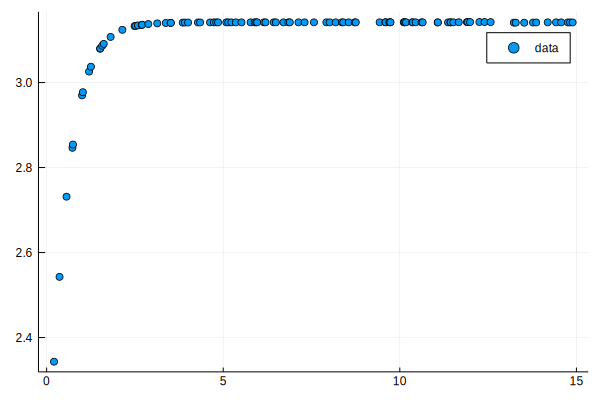

In [12]:
# initial condition  Note: 2.0f0 = 2.0e0 for type Float32 instead of Float64
u0 = Float32[2.0f0] 

# number of samples
datasize = 100

# time horizon,
tspan = (0.0f0,15f0) 

# uniformly distributed points in tspan
t = tspan[1] .+ rand(Float32, datasize)*(tspan[2]-tspan[1])

# true du/dt
f(u,p,t) = 2*sin.(u)

# underlying true ODE]
ode = ODEProblem(f, u0, tspan) 

# solution of the true ODE at time-points t
sol = solve(ode, Tsit5(), saveat=t)

# data
t, u = sol.t, Array(sol)

# plot the solution 
scatter(t, vcat(u...), label="data")

### Neural Network Model

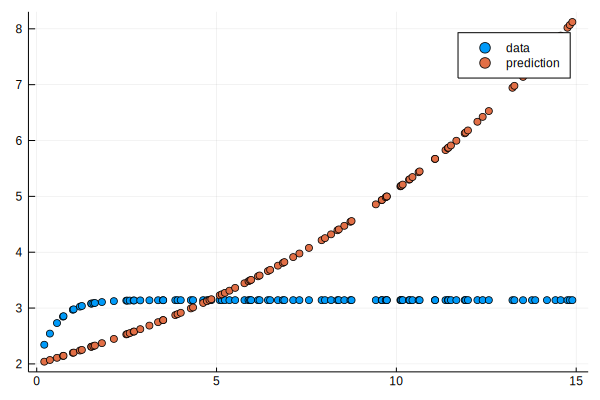

In [13]:
# neural network model
model = Chain(Dense(1,50,relu), Dense(50,100,relu), Dense(100,1))

# ODE solver for the neural network model
n_ode = NeuralODE(model, tspan, Tsit5(), saveat=t)

# prediction for given initial condition
ũ(Φ) = n_ode(u0,Φ)

# plot of the data and the (untrained) neural ODE prediction
scatter(t, vcat(u...), label="data")
scatter!(t, vcat(ũ(n_ode.p)...), label="prediction") 

### Optimization

In [ ]:
# loss 
function loss(Φ) 
    pred = ũ(Φ)
    loss = sum(abs2, u .- pred)
    loss, pred
end

# callback function to observe training
cb = function (p, l, pred; doplot=false) 
  println("Loss: $l")
  if doplot
    pl = scatter(t,vcat(u...),label="data")
    scatter!(pl,t,vcat(pred...),label="prediction")
    display(plot(pl))
  end
  return false
end

# optimize with ADAM
res1 = DiffEqFlux.sciml_train(loss, n_ode.p, ADAM(0.01), cb=cb, maxiters=100)

Loss: 416.5021
Loss: 814.7014
Loss: 882.7627
Loss: 872.156
Loss: 843.9053
Loss: 802.31006
Loss: 740.16425
Loss: 649.7376
Loss: 508.0166
Loss: 269.6748
Loss: 28.319384
Loss: 491.1235
Loss: 73.11875
Loss: 242.67047
Loss: 333.2879
Loss: 371.11438
Loss: 383.85132
Loss: 380.48044
Loss: 365.71405
Loss: 341.90482
Loss: 310.3919
Loss: 272.35886
Loss: 228.62035
Loss: 179.62347
Loss: 127.03169
Loss: 74.32799
Loss: 28.671528
Loss: 3.7499237
Loss: 19.6698
Loss: 72.990265
Loss: 95.293755
Loss: 65.121155
Loss: 26.000713
Loss: 5.37627
Loss: 3.0229206
Loss: 10.055592
Loss: 19.477158
Loss: 27.43418
Loss: 32.237793
Loss: 33.438374
Loss: 31.282377
Loss: 26.443296
Loss: 19.899128
Loss: 12.867579
Loss: 6.7112627
Loss: 2.736106
Loss: 1.8180081
Loss: 3.9013577
Loss: 7.6153083
Loss: 10.79307
Loss: 11.738236
Loss: 10.114291
Loss: 7.0044637
Loss: 3.9549165
Loss: 2.0333202
Loss: 1.5139222
Loss: 2.0742214
Loss: 3.1629813
Loss: 4.2307944
Loss: 4.9039674
Loss: 5.011393
Loss: 4.5690327
Loss: 3.742944
Loss: 2.7820642

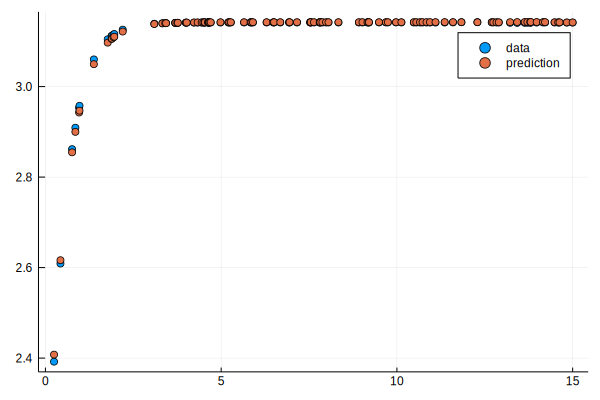

Loss: 0.0010496315


In [71]:
# plot
cb(res1.minimizer, loss(res1.minimizer)...;doplot=true);

In [72]:
# optimize with LBFGS
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, LBFGS(), cb=cb)

Loss: 0.0010496409
Loss: 0.0010468736
Loss: 0.0010455376
Loss: 0.0010454742
Loss: 0.0010394907
Loss: 0.0008520653
Loss: 0.0008478901
Loss: 0.0007895602
Loss: 0.000778737
Loss: 0.00038000842
Loss: 0.00029521217
Loss: 7.78188e-5
Loss: 6.429819e-5
Loss: 2.7990365e-5
Loss: 2.5708001e-5
Loss: 2.5708001e-5


 * Status: success

 * Candidate solution
    Minimizer: [5.99e-02, -2.66e-01, 1.68e-01,  ...]
    Minimum:   2.570800e-05

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [6.82e-02, -2.66e-01, 1.75e-01,  ...]

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 8.73e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   126  (vs limit Inf)
    Iterations:    15
    f(x) calls:    116
    ∇f(x) calls:   116


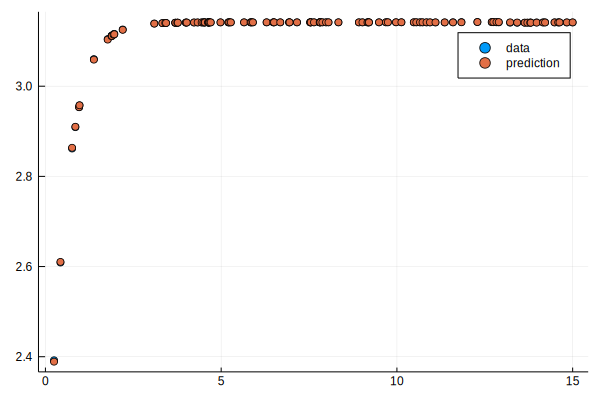

Loss: 2.5705069e-5


In [73]:
# plot
cb(res2.minimizer, loss(res2.minimizer)...;doplot=true);

### Extrapolate

In [95]:
using Interact

ArgumentError: ArgumentError: Package Interact not found in current path:
- Run `import Pkg; Pkg.add("Interact")` to install the Interact package.


In [94]:
@manipulate for u0=0:0.2:4

    u0 = Float32[u_init] 
    ode = ODEProblem(f, u0, tspan) 
    u = Array(solve(ode, Tsit5(), saveat=t))
    ũ = n_ode(u0,res2.minimizer)
    pl = scatter(t,vcat(u...),label="data")
    scatter!(pl,t,vcat(ũ...),label="prediction")
    display(plot(pl))
end

LoadError: UndefVarError: @manipulate not defined

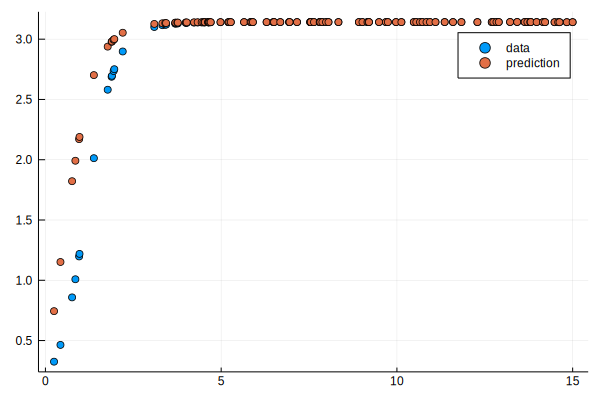

In [86]:
extrapolate(0.2, )